In [1]:
%load_ext lab_black
import datetime
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from typing import List, Tuple
import seaborn as sns
import sys
import wandb
from scipy import stats as sst

In [2]:
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(
    os.getcwd(), "analyze_containstokenset_entropy.ipynb"
)
SAVE_DIR = "../data/FFOOM/"
entity, PROJECT_NAME = "kdu", "bauer-bert-synthetic"  # set to your entity and project
run = wandb.init(
    project=PROJECT_NAME,
    name=f"analyze_containstokenset_entropy_{datetime.datetime.now().isoformat(sep='_', timespec='seconds')}",
    tags=["analysis", "entropy"],
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu. Use `wandb login --relogin` to force relogin
wandb: ERROR Failed to sample metric: Not Supported


{}


In [3]:
valid_run_tags: set = {"containstokenset"}
api = wandb.Api()
runs = api.runs(entity + "/" + PROJECT_NAME)
summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    if valid_run_tags.intersection(set(run.tags)):
        if "analysis" not in run.tags:
            summary_list.append(run.summary._json_dict)

            # .config contains the hyperparameters.
            #  We remove special values that start with _.
            config_list.append(
                {k: v for k, v in run.config.items() if not k.startswith("_")}
            )

            # .name is the human-readable name of the run.
            name_list.append(run.name)

runs_df = pd.DataFrame(
    {"summary": summary_list, "config": config_list, "name": name_list}
)

In [4]:
runs_df = runs_df[(runs_df["summary"] != dict()) & (runs_df["config"] != dict())]
runs_df

,summary,config,name
0,"{'_step': 1849, 'train': {'batch': 43, 'epoch'...","{'SEED': 2, 'TAGS': ['containstokenset'], 'L1_...",comfy-cherry-156
1,"{'train_model_time': 13.128165557980536, 'eval...","{'SEED': 1, 'TAGS': ['containstokenset'], 'L1_...",frosty-meadow-155
2,"{'init_model_time': 0.09249551896937191, 'trai...","{'SEED': 0, 'TAGS': ['containstokenset'], 'L1_...",quiet-valley-154
3,"{'_timestamp': 1679582452.7288525, 'eval_model...","{'SEED': 4, 'TAGS': ['containstokenset'], 'L1_...",gallant-deluge-153
4,"{'_runtime': 134.24382853507996, '_timestamp':...","{'SEED': 3, 'TAGS': ['containstokenset'], 'L1_...",vital-snowball-151
...,...,...,...
65,"{'_step': 926, 'train': {'batch': 21, 'epoch':...","{'SEED': 1, 'TAGS': ['containstokenset', 'toke...",wandering-fire-82
66,"{'_runtime': 40.29371500015259, 'init_model_ti...","{'SEED': 0, 'TAGS': ['containstokenset', 'toke...",copper-dust-81
67,"{'_step': 926, 'train': {'batch': 21, 'epoch':...","{'SEED': 2, 'TAGS': ['containstokenset', 'toke...",vague-grass-80
68,"{'test': {'loss': 0.6331759691238403, 'entropy...","{'SEED': 1, 'TAGS': ['containstokenset', 'toke...",gallant-oath-79


In [5]:
def convert_dict_to_df(df, col_name):
    return df[col_name].apply(lambda row: pd.Series(row))

In [6]:
expanded_df = pd.concat(
    [
        convert_dict_to_df(runs_df, "summary"),
        convert_dict_to_df(runs_df, "config"),
        convert_dict_to_df(
            convert_dict_to_df(runs_df, "config"), "DATASET_KWARGS_IDENTIFIABLE"
        ),
        convert_dict_to_df(convert_dict_to_df(runs_df, "summary"), "test"),
        runs_df[["name"]],
    ],
    axis=1,
)
expanded_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 69
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   _step                        70 non-null     int64  
 1   train                        70 non-null     object 
 2   _wandb                       69 non-null     object 
 3   _runtime                     70 non-null     float64
 4   init_model_time              68 non-null     float64
 5   eval_model_nvidia_mem_used   65 non-null     object 
 6   init_model_nvidia_mem_used   65 non-null     object 
 7   test                         69 non-null     object 
 8   eval_model_time              68 non-null     float64
 9   train_model_time             68 non-null     float64
 10  _timestamp                   70 non-null     float64
 11  SEED                         70 non-null     int64  
 12  TAGS                         70 non-null     object 
 13  L1_WEIGHT             

In [7]:
expanded_df["token_set"] = expanded_df["token_set"].map(tuple)
print(expanded_df["token_set"].unique())
expanded_df["token_set"].isin({(1, 2, 3, 4, 5)})

[(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11) (1, 2, 3) (1, 2, 3, 4, 5, 6, 7, 8, 9)
 (1, 2, 3, 4, 5, 6, 7) (1, 2, 3, 4, 5) (1,)]


0     False
1     False
2     False
3     False
4     False
      ...  
65    False
66    False
67    False
68    False
69    False
Name: token_set, Length: 70, dtype: bool

In [8]:
entropy_accuracy_df = expanded_df[
    [
        "token_set",
        "SEED",
        "accuracy",
        "entropy",
        "loss",
        "num_points",
    ]
]
entropy_accuracy_df

,token_set,SEED,accuracy,entropy,loss,num_points
0,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)",2,0.9575,454.829590,0.165715,2000
1,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)",1,0.9500,455.175273,0.185361,2000
2,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)",0,0.9575,458.204463,0.185208,2000
3,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)",4,0.9650,444.316216,0.115017,2000
4,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)",3,0.9600,444.381045,0.143390,2000
...,...,...,...,...,...,...
65,"(1, 2, 3)",1,0.8400,302.397805,0.525392,1000
66,"(1, 2, 3)",0,0.8600,302.498535,0.439611,1000
67,"(1,)",2,0.7400,298.495156,0.754184,1000
68,"(1,)",1,0.7600,300.696401,0.633176,1000


In [9]:
valid_num_points = set([2000])
entropy_accuracy_df = entropy_accuracy_df[
    entropy_accuracy_df["num_points"].isin(valid_num_points)
]
entropy_accuracy_df = entropy_accuracy_df[entropy_accuracy_df["entropy"].notna()]
entropy_accuracy_df["accuracy_sq"] = np.square(entropy_accuracy_df["accuracy"])
entropy_accuracy_df["entropy_sq"] = np.square(entropy_accuracy_df["entropy"])

entropy_accuracy_df

,token_set,SEED,accuracy,entropy,loss,num_points,accuracy_sq,entropy_sq
0,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)",2,0.9575,454.829590,0.165715,2000,0.916806,206869.955797
1,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)",1,0.9500,455.175273,0.185361,2000,0.902500,207184.529549
2,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)",0,0.9575,458.204463,0.185208,2000,0.916806,209951.329813
3,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)",4,0.9650,444.316216,0.115017,2000,0.931225,197416.899641
4,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)",3,0.9600,444.381045,0.143390,2000,0.921600,197474.513086
6,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)",2,0.9500,456.361570,0.171377,2000,0.902500,208265.882412
7,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)",1,0.9350,454.459011,0.202063,2000,0.874225,206532.992889
8,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)",0,0.9450,451.996733,0.161457,2000,0.893025,204301.047003
14,"(1, 2, 3, 4, 5, 6, 7, 8, 9)",4,0.9075,453.240078,0.290467,2000,0.823556,205426.568419
15,"(1, 2, 3, 4, 5, 6, 7, 8, 9)",3,0.9300,461.031384,0.231732,2000,0.864900,212549.937289


0.3206939574075286 0.06881826945494138


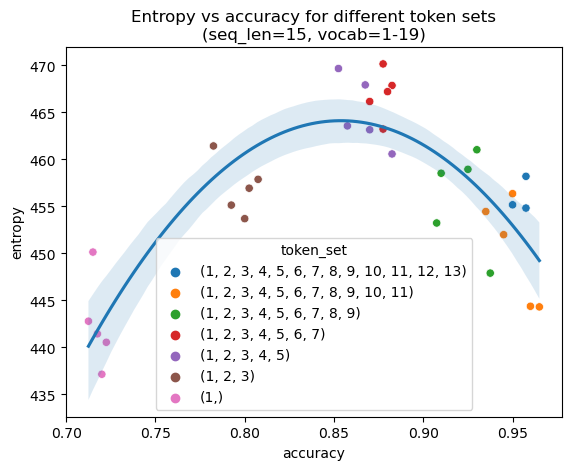

wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error resolved after 0:00:08.871228, resuming normal operation.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.


In [11]:
ax = sns.scatterplot(
    data=entropy_accuracy_df, x="accuracy", y="entropy", hue="token_set"
)

# Linear
# ax = sns.regplot(
#     data=entropy_accuracy_df, x="accuracy", y="entropy", scatter=False, ax=ax
# )

# Quadratic
ax = sns.regplot(
    data=entropy_accuracy_df, x="accuracy", y="entropy", order=2, scatter=False, ax=ax
)

r, p = sst.pearsonr(entropy_accuracy_df["accuracy"], entropy_accuracy_df["entropy"])


def annotate(data, **kws):
    r, p = sst.pearsonr(entropy_accuracy_df["accuracy"], entropy_accuracy_df["entropy"])
    ax = plt.gca()
    ax.text(0.05, 0.8, "r={:.2f}, p={:.2g}".format(r, p), transform=ax.transAxes)


print(r, p)
ax.set_title(
    f"Entropy vs accuracy for different token sets"
    "\n(seq_len=15, vocab=1-19)"
    # "\nr={r:.2f}, p={p:.2g}"
)
plt.show()

0.512782801077685 0.005267387635545024


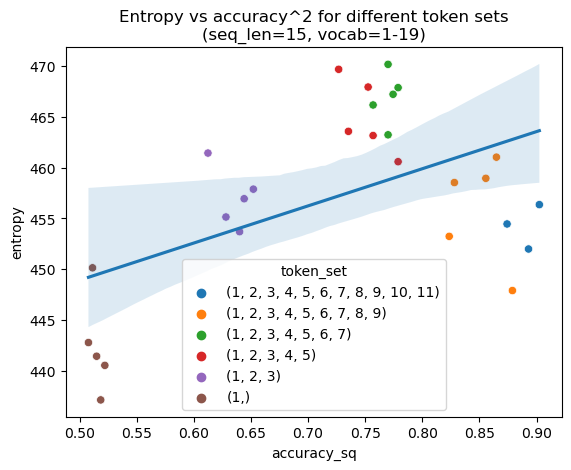

In [22]:
# entropy vs acc^2
ax = sns.scatterplot(
    data=entropy_accuracy_df, x="accuracy_sq", y="entropy", hue="token_set"
)
ax = sns.regplot(
    data=entropy_accuracy_df,
    x="accuracy_sq",
    y="entropy",
    # order=2,
    scatter=False,
    ax=ax,
)

r, p = sst.pearsonr(entropy_accuracy_df["accuracy_sq"], entropy_accuracy_df["entropy"])


def annotate(data, **kws):
    r, p = sst.pearsonr(
        entropy_accuracy_df["accuracy_sq"], entropy_accuracy_df["entropy"]
    )
    ax = plt.gca()
    ax.text(0.05, 0.8, "r={:.2f}, p={:.2g}".format(r, p), transform=ax.transAxes)


print(r, p)
ax.set_title(
    f"Entropy vs accuracy^2 for different token sets"
    "\n(seq_len=15, vocab=1-19)"
    # "\nr={r:.2f}, p={p:.2g}"
)
plt.show()

<AxesSubplot: xlabel='loss', ylabel='entropy'>

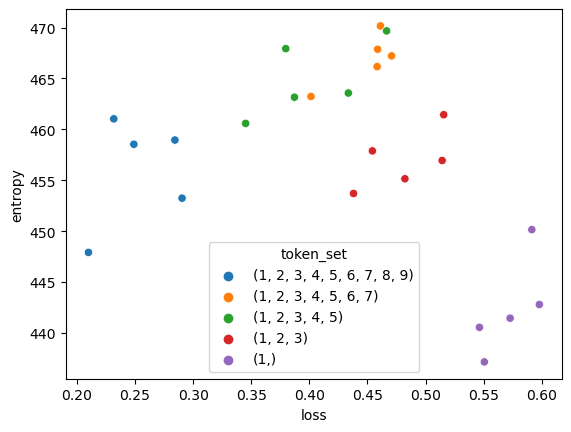

In [19]:
sns.scatterplot(data=entropy_accuracy_df, x="loss", y="entropy", hue="token_set")

In [26]:
valid_hidden_szs = set([64])
valid_num_points = set([5000])
valid_seeds = set([1, 2, 3])

In [27]:
expanded_df = expanded_df[expanded_df["entropy"].notna()]
expanded_df = expanded_df[expanded_df["grads_per_input_feature"].notna()]
expanded_df = expanded_df[expanded_df["HIDDEN_SIZE"].isin(valid_hidden_szs)]
expanded_df = expanded_df[expanded_df["num_points"].isin(valid_num_points)]
expanded_df = expanded_df[expanded_df["SEED"].isin(valid_seeds)]
expanded_df = expanded_df[expanded_df["PM_RUN_ID"].notna()]
expanded_df = expanded_df[expanded_df["L1_WEIGHT"].notna()]
expanded_df = expanded_df[expanded_df["L2_WEIGHT"].notna()]
# expanded_df = expanded_df[expanded_df["L2_WEIGHT"] == 0.5]
expanded_df = expanded_df[expanded_df["name"].notna()]
expanded_df = expanded_df[expanded_df["DROPOUT_PROB"].notna()]

In [28]:
expanded_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   all                          30 non-null     object 
 1   strata_4                     30 non-null     object 
 2   strata_0                     30 non-null     object 
 3   strata_5                     30 non-null     object 
 4   strata_6                     30 non-null     object 
 5   train_model_time             30 non-null     float64
 6   init_model_nvidia_mem_used   0 non-null      object 
 7   batch                        30 non-null     int64  
 8   unregularized_loss           30 non-null     float64
 9   grads_per_input_feature      30 non-null     object 
 10  loss                         30 non-null     float64
 11  _wandb                       30 non-null     object 
 12  _runtime                     30 non-null     float64
 13  strata_7              

In [29]:
expanded_df["validation_entropy_relevant"] = expanded_df["all"].apply(
    lambda x: x["total_entropy_relevant"]
)
expanded_df["validation_entropy_irrelevant"] = expanded_df["all"].apply(
    lambda x: x["total_entropy_irrelevant"]
)

In [45]:
expanded_df = expanded_df[
    [
        # "name",
        "entropy",
        "entropy_per_input_feature",
        "grads_per_input_feature",
        "accuracy",
        "loss",
        "HIDDEN_SIZE",
        "SEED",
        "num_points",
        "DROPOUT_PROB",
        "validation_entropy_relevant",
        "validation_entropy_irrelevant",
    ]
]
expanded_df = expanded_df.drop_duplicates(
    subset=[
        "entropy",
        "accuracy",
        "loss",
        "HIDDEN_SIZE",
        "SEED",
        "DROPOUT_PROB",
        "num_points",
        "validation_entropy_relevant",
        "validation_entropy_irrelevant",
    ]
)

In [53]:
expanded_df_long = expanded_df.melt(
    id_vars=["DROPOUT_PROB", "SEED"],
    value_vars=["validation_entropy_relevant", "validation_entropy_irrelevant"],
    var_name="relevant_vs_irrelevant",
    value_name="entropy",
)
expanded_df_long

/tmp/ipykernel_76290/3771552018.py:1: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  expanded_df_long = expanded_df.melt(


,DROPOUT_PROB,SEED,relevant_vs_irrelevant,entropy
0,0.8,3,validation_entropy_relevant,4.863900
1,0.6,3,validation_entropy_relevant,4.904433
2,0.4,3,validation_entropy_relevant,4.942160
3,0.2,3,validation_entropy_relevant,4.955382
4,0.0,3,validation_entropy_relevant,4.967991
5,0.8,2,validation_entropy_relevant,4.810174
6,0.6,2,validation_entropy_relevant,4.939161
7,0.4,2,validation_entropy_relevant,4.961919
8,0.2,2,validation_entropy_relevant,5.002855
9,0.0,2,validation_entropy_relevant,5.007968


Text(0.5, 1.0, 'Entropy (averaged over validation set and seeds) \nvs\ndropout rate of MLP\n(HS=64, n=5000)')

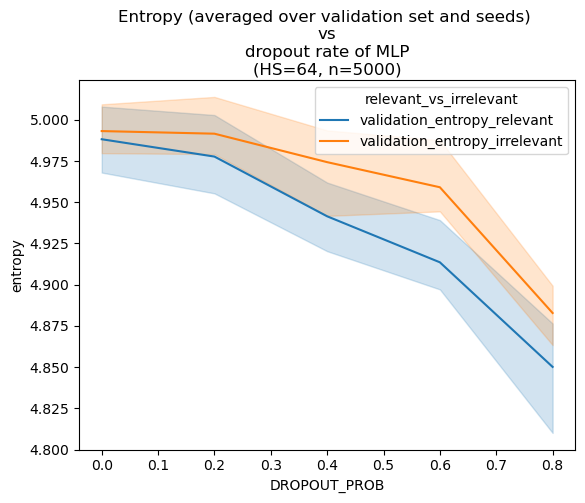

In [59]:
fig, ax = plt.subplots()
sns.lineplot(
    data=expanded_df_long, x="DROPOUT_PROB", y="entropy", hue="relevant_vs_irrelevant"
)
ax.set_title(
    "Entropy (averaged over validation set and seeds) \nvs\ndropout rate of MLP\n(HS=64, n=5000)",
    wrap=True,
)

In [12]:
expanded_df = expanded_df.reset_index()
entropy_per_input_feature_df = pd.DataFrame(
    expanded_df["entropy_per_input_feature"].to_list()
).add_prefix("f")
expanded_df = pd.concat([expanded_df, entropy_per_input_feature_df], axis=1)
expanded_df = expanded_df.rename(columns={"f0": "relevant_feature"})
expanded_df["mean_irrelevant_features"] = expanded_df[["f1", "f2", "f3"]].mean(axis=1)

In [13]:
grads_per_input_feature_df = pd.DataFrame(
    expanded_df["grads_per_input_feature"].to_list()
).add_prefix("g")
expanded_df = pd.concat([expanded_df, grads_per_input_feature_df], axis=1)
expanded_df = expanded_df.rename(columns={"g0": "relevant_feature_grad"})
expanded_df["mean_irrelevant_features_grad"] = expanded_df[["g1", "g2", "g3"]].mean(
    axis=1
)

In [20]:
expanded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          5 non-null      int64  
 1   name                           5 non-null      object 
 2   entropy                        5 non-null      float64
 3   entropy_per_input_feature      5 non-null      object 
 4   grads_per_input_feature        5 non-null      object 
 5   accuracy                       5 non-null      float64
 6   loss                           5 non-null      float64
 7   HIDDEN_SIZE                    5 non-null      int64  
 8   SEED                           5 non-null      int64  
 9   num_points                     5 non-null      int64  
 10  DROPOUT_PROB                   5 non-null      float64
 11  relevant_feature               5 non-null      float64
 12  f1                             5 non-null      float64

### Construct long-form datasets for entropy (per feature) and accuracy

In [21]:
expanded_df_long = pd.melt(
    expanded_df,
    id_vars=["DROPOUT_PROB", "num_points"],
    value_vars=["relevant_feature", "mean_irrelevant_features"],
    # value_vars=["f0", "f1", "f2", "f3"],
    var_name="metric",
    value_name="entropy",
)
expanded_df_long

expanded_df_long_grads = pd.melt(
    expanded_df,
    id_vars=["DROPOUT_PROB", "num_points"],
    value_vars=["relevant_feature_grad", "mean_irrelevant_features_grad"],
    # value_vars=["f0", "f1", "f2", "f3"],
    var_name="metric",
    value_name="grad",
)
expanded_df_long_grads

expanded_df_long_accuracy = pd.melt(
    expanded_df,
    id_vars=["DROPOUT_PROB", "num_points"],
    value_vars=["accuracy"],
    var_name="metric",
    value_name="accuracy",
)
expanded_df_long_accuracy

expanded_df_long_accuracy = pd.melt(
    expanded_df,
    id_vars=["DROPOUT_PROB", "num_points"],
    value_vars=["accuracy"],
    var_name="metric",
    value_name="accuracy",
)
expanded_df_long_accuracy

/tmp/ipykernel_56548/4226170903.py:1: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  expanded_df_long = pd.melt(
/tmp/ipykernel_56548/4226170903.py:21: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  expanded_df_long_accuracy = pd.melt(
/tmp/ipykernel_56548/4226170903.py:30: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  expanded_df_long_accuracy = pd.melt(


,DROPOUT_PROB,num_points,metric,accuracy
0,0.0,5000,accuracy,0.914
1,0.8,5000,accuracy,0.763
2,0.6,5000,accuracy,0.898
3,0.4,5000,accuracy,0.908
4,0.2,5000,accuracy,0.913


In [22]:
table = wandb.Table(dataframe=expanded_df_long)
wandb.log({"relevant_runs_table_entropy": table})
accuracy_table = wandb.Table(dataframe=expanded_df_long_accuracy)
wandb.log({"relevant_runs_table_accuracy": accuracy_table})

### Plot the entropy for the relevant feature and irrelevant features

1


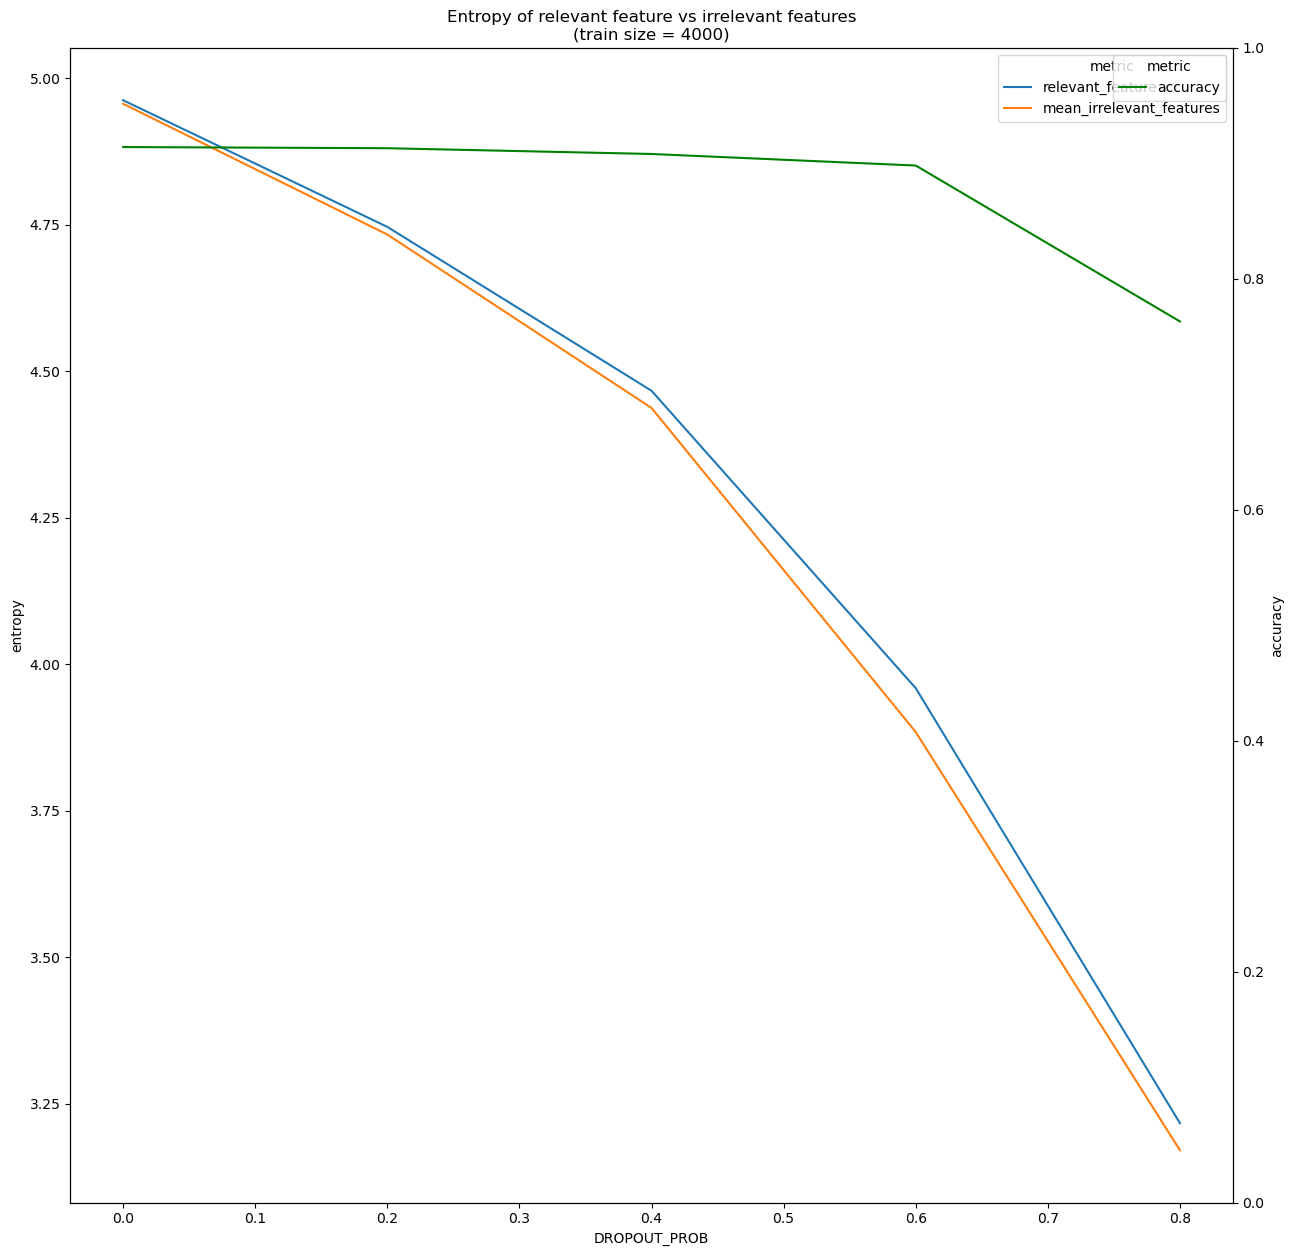

In [23]:
ds_sizes = sorted(expanded_df_long["num_points"].unique())
num_ds_sizes = len(ds_sizes)
print(num_ds_sizes)
num_cols = 1
num_rows = int(num_ds_sizes / num_cols)
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 15))
for i in range(num_ds_sizes):
    ds_size = ds_sizes[i]
    sns.lineplot(
        data=expanded_df_long[expanded_df_long["num_points"] == ds_size],
        x="DROPOUT_PROB",
        y="entropy",
        hue="metric",
        ax=ax
        # style="num_points",
    )
    ax2 = ax.twinx()
    sns.lineplot(
        data=expanded_df_long_accuracy[
            expanded_df_long_accuracy["num_points"] == ds_size
        ],
        x="DROPOUT_PROB",
        y="accuracy",
        hue="metric",
        ax=ax2,
        palette=["g"]
        # style="num_points",
    )
    ax2.set_ylim((0.0, 1.0))

    ax.set_title(
        f"Entropy of relevant feature vs irrelevant features\n(train size = {int(ds_size * 0.8)})"
    )

plt.savefig(os.path.join(SAVE_DIR, "entropy_relevant_vs_irrelevants_feats.png"))
wandb.log(
    {
        "plot": wandb.Image(
            os.path.join(SAVE_DIR, "entropy_relevant_vs_irrelevants_feats.png")
        )
    }
)

2


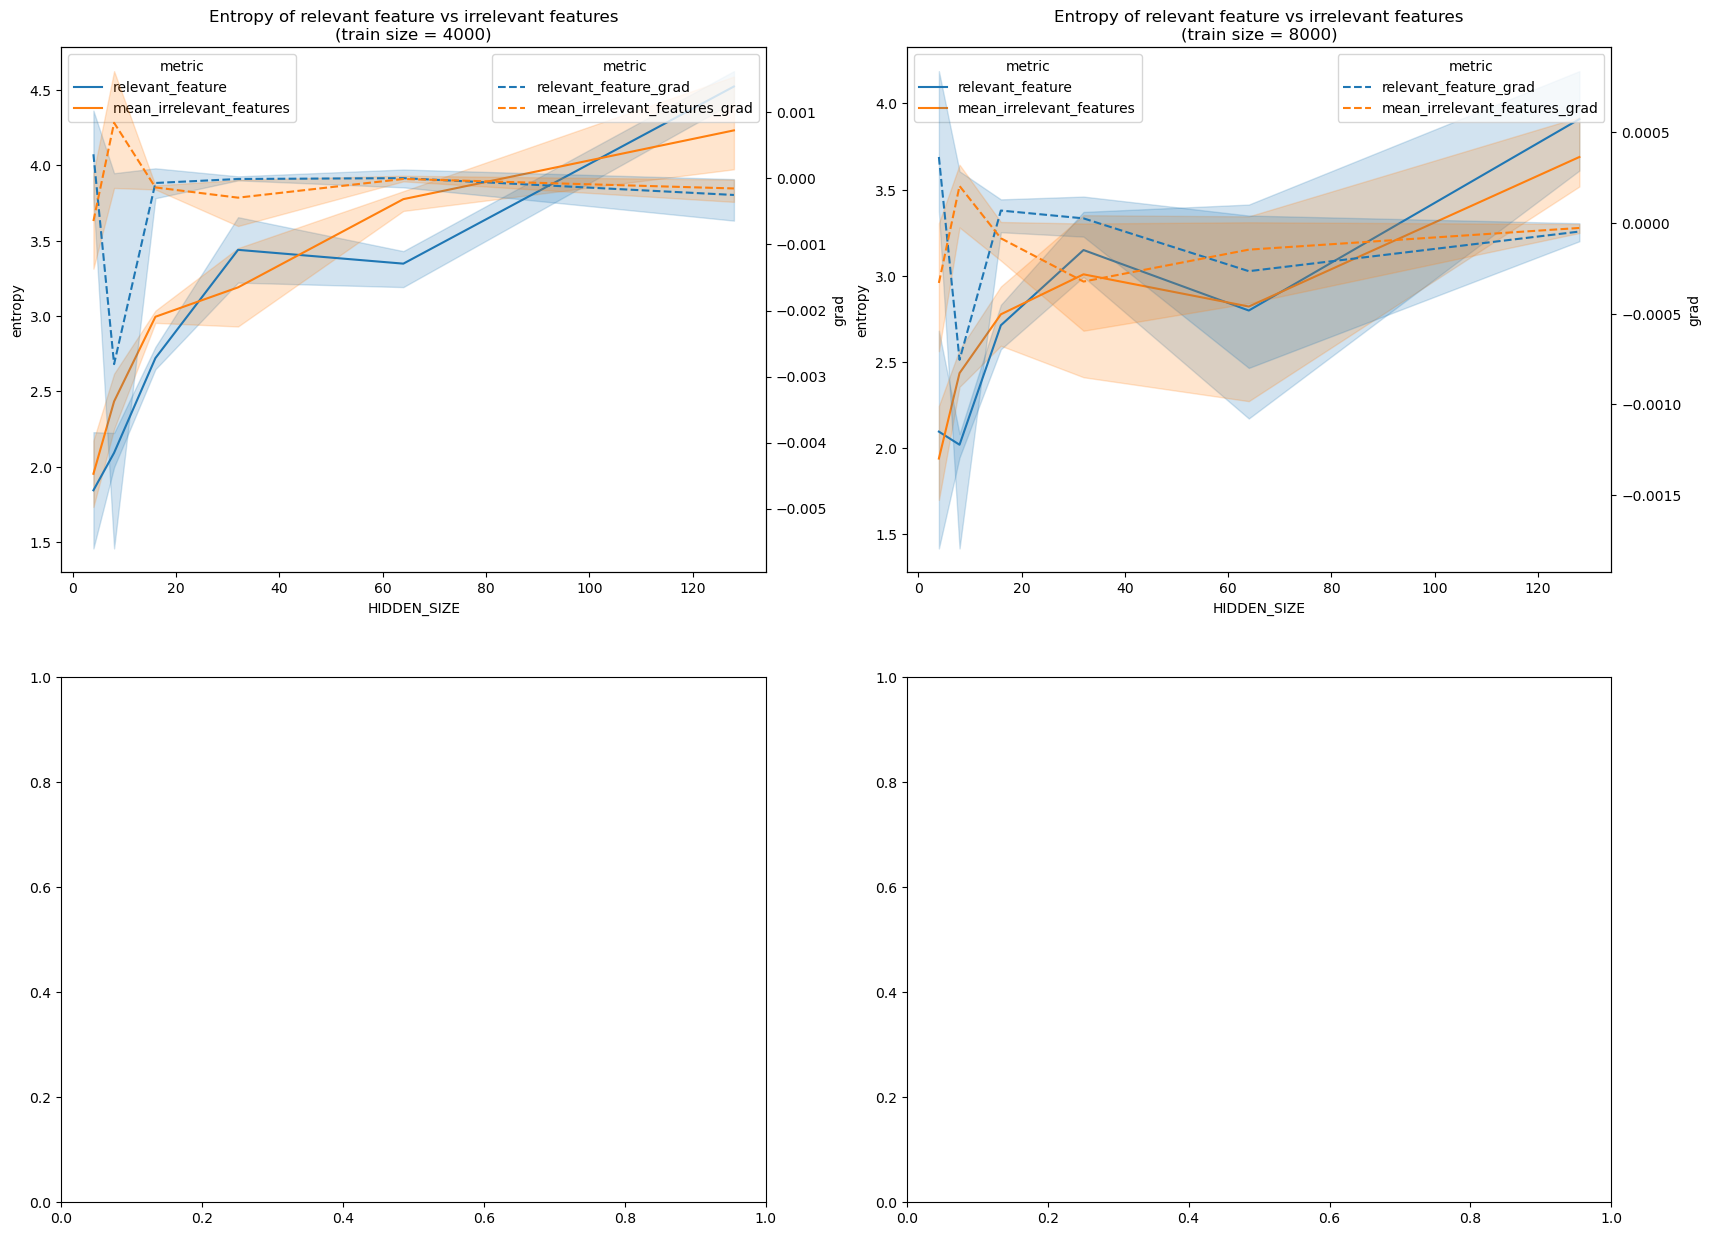

In [16]:
ds_sizes = sorted(expanded_df_long["num_points"].unique())
num_ds_sizes = len(ds_sizes)
print(num_ds_sizes)
fig, axes = plt.subplots(num_rows, 2, figsize=(20, 15))
for i in range(num_ds_sizes):
    ds_size = ds_sizes[i]
    sns.lineplot(
        data=expanded_df_long[expanded_df_long["num_points"] == ds_size],
        x="HIDDEN_SIZE",
        y="entropy",
        hue="metric",
        ax=axes[int(i / 2)][int(i % 2)]
        # style="num_points",
    )
    ax2 = axes[int(i / 2)][int(i % 2)].twinx()
    sns.lineplot(
        data=expanded_df_long_grads[expanded_df_long_grads["num_points"] == ds_size],
        x="HIDDEN_SIZE",
        y="grad",
        hue="metric",
        ax=ax2,
        linestyle="dashed"
        # style="num_points",
    )
    leg = ax2.get_legend()
    [ll.set_linestyle("--") for ll in leg.get_lines()]

    axes[int(i / 2)][int(i % 2)].set_title(
        f"Entropy of relevant feature vs irrelevant features\n(train size = {int(ds_size * 0.8)})"
    )

plt.savefig(os.path.join(SAVE_DIR, "entropy_relevant_vs_irrelevants_feats_w_grads.png"))
wandb.log(
    {
        "plot": wandb.Image(
            os.path.join(SAVE_DIR, "entropy_relevant_vs_irrelevants_feats_w_grads.png")
        )
    }
)

In [17]:
wandb.finish()